<a href="https://colab.research.google.com/github/sayakpaul/Multimodal-Entailment-Baseline/blob/main/multimodal_entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In today's world information is mostly found in unstructured or semi-structured form as videos, texts, images, audios, etc. Therefore, to capture their inter-relationships we need to allow deep models take multimodal inputs i.e. text, images, etc. On social media platforms, to audit and moderate content we often need to find answers to the following questions in near real-time:

* Does a given piece of information contradict the other?
* Does a given piece of information imply the other?

In NLP, this task is referred to as recognizing textual entailment that only deals with texts as inputs. But in this case, we can have different inputs modalities. In this example, we will build and train a model for predicting multimodal entailment. We will be using the [multimodal entailment dataset](https://github.com/google-research-datasets/recognizing-multimodal-entailment) recently introduced by Google Research.

This example requires TensorFlow 2.5 or higher. In addition, TensorFlow Hub and TensorFlow Text are required for the BERT model ([Devlin et al.](https://arxiv.org/abs/1810.04805)). These libraries can be installed using the following command:

In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.3 MB 16.8 MB/s 


## Collect the dataset

The original dataset is available [here](https://github.com/google-research-datasets/recognizing-multimodal-entailment). However, we will be using a better prepared version of the dataset. Thanks to [Nilabhra Roy Chowdhury](https://de.linkedin.com/in/nilabhraroychowdhury) who worked on the preparation. 

In [2]:
!wget -q https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz
!tar xf tweet_images.tar.gz

## Imports

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

## Define a label map

In [2]:
label_map = {
    "Contradictory": 0,
    "Implies": 1,
    "NoEntailment": 2
}

## Read the dataset and apply basic preprocessing

In [3]:
df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv")
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
883,1377904670887141377,"Life is a maybe, Death is for sure. Sin is the...",http://pbs.twimg.com/media/Ex9AeNUVEAQP5Lx.jpg,1378068662821683200,Bless everyone in these trying times. Let's al...,http://pbs.twimg.com/media/Ex_iJVhVoAAQc19.jpg,NoEntailment
608,1373837520580931587,World #water day reminds that we should follow...,http://pbs.twimg.com/media/ExBrKspVgAAPgS7.jpg,1373937542266028032,Water is an extremely precious resource withou...,http://pbs.twimg.com/media/ExE06eiXAAEmOSO.jpg,NoEntailment
172,1376805213978431492,"#Fortnite Item Shop for Tuesday, March 30, 202...",http://pbs.twimg.com/media/ExtlBztXMAcIeGy.jpg,1381759253799698434,"#Fortnite Item Shop for Tuesday, April 13, 202...",http://pbs.twimg.com/media/Eyz-tLYWEAEachG.jpg,Contradictory
143,1366133593945346052,The sell orders of XBASE just decreased with -...,http://pbs.twimg.com/media/EvV7Q2fXYAATSOT.jpg,1367949314828419078,The sell orders of XBASE just decreased with -...,http://pbs.twimg.com/media/EvvupuMXAAIbmFt.jpg,Contradictory
1033,1362553877544001537,New Fortnite Item Shop - 19. 02. 2021\n\nUse c...,http://pbs.twimg.com/media/EujDhuJXYAAFUr5.jpg,1383588404261113857,New Fortnite Item Shop - 18. 04. 2021\n\nUse c...,http://pbs.twimg.com/media/EzN-ULwUYAIGY_w.jpg,NoEntailment
1144,1359661816809357313,"Westlock area COVID-19 update: 7 active cases,...",http://pbs.twimg.com/media/Et59N5RU0AEAKjQ.jpg,1361813747157803009,"Westlock area COVID-19 update: 4 active cases,...",http://pbs.twimg.com/media/EuYiYulVgAEOJ7w.jpg,NoEntailment
829,1372930378185506821,#XAUUSD SSI is at 1.85\n\nRisk Warning: Losses...,http://pbs.twimg.com/media/Ew2g513WUAkvChB.png,1380376942738817024,#AUDJPY SSI is at -1.09\n\nRisk Warning: Losse...,http://pbs.twimg.com/media/EygVg9EXEAEC3BX.png,NoEntailment
349,1344341983536549889,PODCAST: Your Sports Fix is back at it again w...,http://pbs.twimg.com/media/EqTTfWpXMAALODr.png,1382121673923629058,PODCAST: Your Sports Fix is back at it again w...,http://pbs.twimg.com/media/EyzZAu4XMAIAJsD.png,Implies
1014,1373317587291926530,SsamMyway won Hearthstone Masters Qualifier Or...,http://pbs.twimg.com/media/Ew7zf4dWgAMEM35.jpg,1377936996384043012,Alpe won Hearthstone Masters Qualifier Orgrimm...,http://pbs.twimg.com/media/Ex9qZV3W8AE_u62.jpg,NoEntailment
667,1335176649109803008,@NjapitMwaana @YEDNetworkKe @MOH_Kenya lets he...,http://pbs.twimg.com/media/EoeAFYJXMAI455J.jpg,1335203090543366144,@CourtneyRuchugi Let's join our hands together...,http://pbs.twimg.com/media/EoeYIkbXUAAoaqQ.jpg,NoEntailment


The columns we are interested in are the following:

* `text_1`
* `image_1`
* `text_2`
* `image_2`
* `label`

The entailment task is formulated as the following:

***Given the pairs of (`text_1`, `image_1`) and (`text_2`, `image_2`) do they entail (or not entail or contradict) each other?*** 

We have the images already downloaded. `image_1` is downloaded as `id1` as its filename and `image2` is downloaded as `id2` as its filename. In the next step, we will add two more columns to `df` - filepaths of `image_1`s and `image_2`s. 

In [4]:
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".") [-1]
    extentsion_two = current_row["image_2"].split(".") [-1]
    
    image_one_path = os.path.join("tweet_images", str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join("tweet_images", str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

In [5]:
df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

In [6]:
# Create another column containing the integer ids of 
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])

## Dataset visualization

In [7]:
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")

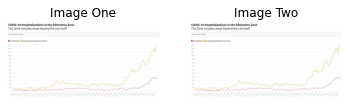

Text one: 📊Edmonton (zone) hospitalizations 
*163 total ⬇️1
  -37 in ICU⬆️2 
  -126 not in ICU ⬇️3 

*3 straight days with 160+ hospitalizations
*37 in ICU ties for 2nd highest to date
https://t.co/icdrQycNDD
#COVID19AB #yeg https://t.co/L0r17vWbA6
Text two: 📊Edmonton (zone) hospitalizations 
*169 total ⬆️6
  -39 in ICU --  
  -130 not in ICU ⬆️ 6

*5 straight reporting days with 160+ hospitalizations &amp; 35+ ICU patients

*35 or more ICU patients since Nov 16

https://t.co/icdrQxVcM5
#COVID19AB #yeg https://t.co/afCDS3GZfy
Label: NoEntailment


In [8]:
random_idx = np.random.choice(len(df))
visualize(random_idx)

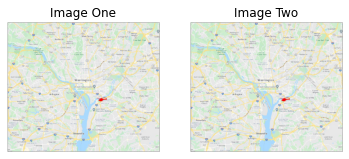

Text one: Aircraft #N22PP operated by U.S. Park Police is over Latitude: 38.87 and Longitude: -76.99 flying at Altitude: 7.62ft. #ParkPolice #ADSB https://t.co/qDD2tPT2z4
Text two: Aircraft #N22PP operated by U.S. Park Police is over Latitude: 38.8 and Longitude: -76.89 flying at Altitude: 274.32ft. #ParkPolice #ADSB https://t.co/aUJcKfZngo
Label: NoEntailment


In [9]:
random_idx = np.random.choice(len(df))
visualize(random_idx)

## Train/test split

The dataset suffers from [class imbalance problem](https://developers.google.com/machine-learning/glossary#class-imbalanced-dataset). We can confirm that in the following cell.

In [10]:
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

To account for that we will go for a stratified split. 

In [11]:
# 10% for test
train_df, test_df = train_test_split(df, test_size=0.1, 
                                     stratify=df["label"].values, random_state=42)
# 5% for validation
train_df, val_df = train_test_split(train_df, test_size=0.05, 
                                     stratify=train_df["label"].values, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


## Data input pipeline

TensorFlow Hub [provides](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub) a variety of BERT family of models. Each of those models comes with a corresponding preprocessing layer. You can know more about these models and the preprocessing layers from [here](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub). 

To keep the runtime of this example relatively shorter we will use a smaller variant of the original BERT model. 

In [14]:
# Define TF Hub paths to the BERT encoder and its preprocessor.
bert_model_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

Our text preprocessing code mostly comes from [this tutorial](https://www.tensorflow.org/text/tutorials/bert_glue). You are highly encouraged to check out this tutorial to know more about BERT input preprocessing. 

In [15]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(bert_preprocess_path)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return keras.Model(input_segments, model_inputs)

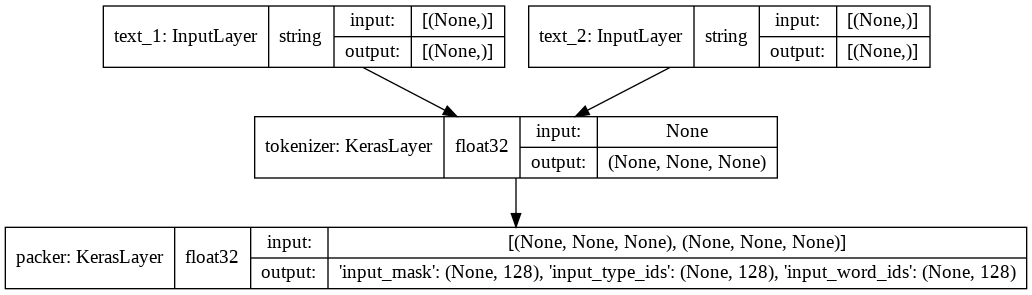

In [16]:
bert_preprocess_model = make_bert_preprocess_model(['text_1', 'text_2'])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

### Run the preprocessor on a sample input

In [17]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

Text 1: Friends, interested all go to have a look!
@desireebackup @viibabbyy @GlazeKota @FemaIeStruggIee @itsabbeyyyyy @JB__Accessories @XoSsamanthaa @KapitulE33 @FunSays @Kovas https://t.co/xnmo9AW7uG
Text 2: Friends, interested all go to have a look!
@MjKing1717 @j_men52 @dianawoo87 @MongaleeS @keistle @Fuentesjo6 @LadyPookz @earthdeckhack @borinory24 @randyasuarez https://t.co/xGBq8QU46f


In [18]:
test_text = [np.array([sample_text_1]),
    np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2814  1010  4699  2035  2175  2000  2031  1037  2298   999  1030
  4792 15878  8684  6279], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


We will now create `tf.data.Dataset` objects from the dataframes for performance.

Note that the text inputs will be preprocessed as a part of the data input pipeline. But the preprocessing modules can also be a part of their corresponding BERT models. This helps reduce the training/serving skew and lets our models operate with raw text inputs. Follow [this tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) to know more about how to incorporate the preprocessing modules directly inside the models. 

### Other preprocessing utilities

In [19]:
# Reference:
# https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

In [20]:
resize = (128, 128)
bert_input_features = ['input_word_ids', 'input_type_ids', 'input_mask']

def read_resize(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) 
        for feature in bert_input_features}
    return output

def preprocess(sample):
    image_1 = read_resize(sample["image_1_path"])
    image_2 = read_resize(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

### Create the final datasets

In [21]:
batch_size = 32
auto = tf.data.AUTOTUNE

def prepare_dataset(df, training=True):
    ds = dataframe_to_dataset(df)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess(x), y))
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [22]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [23]:
# Separate the train and test labels for later evaluation.
def separate_labels(ds):
    labels = []
    for _, label in ds.unbatch():
        labels.append(label)
    labels = np.array(labels)
    return labels

train_labels = separate_labels(train_ds)
test_labels = separate_labels(test_ds)

In [24]:
train_labels.shape, test_labels.shape

((1197,), (140,))

## Model building utilities

Our final model will accept two images along with their text counterparts. While the images will be directly fed to the model the text inputs will first be preprocessed and then will make it to the model. Below is a pictorial depiction of this approach:

![](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/figures/brief_architecture.png)

The model consists of the following elements:

* A standalone encoder for the images. We will use a [ResNet50V2](https://arxiv.org/abs/1603.05027) pre-trained on the ImageNet-1k dataset for this.
* A stanalone encoder for the images. A pre-trained BERT will be used for this. 

After extracting the individual embeddings, they will be projected in an identical space. Finally, their projections will be concatenated and be fed to the final classification layer. 

This is a multi-class classification problem involving the following classes:

* NoEntailment     
* Implies           
* Contradictory     

`project_embeddings()`, `create_vision_encoder()`, and `create_text_encoder()` utilities are referred from [this example](https://keras.io/examples/nlp/nl_image_search/). 

In [25]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [26]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable
    
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

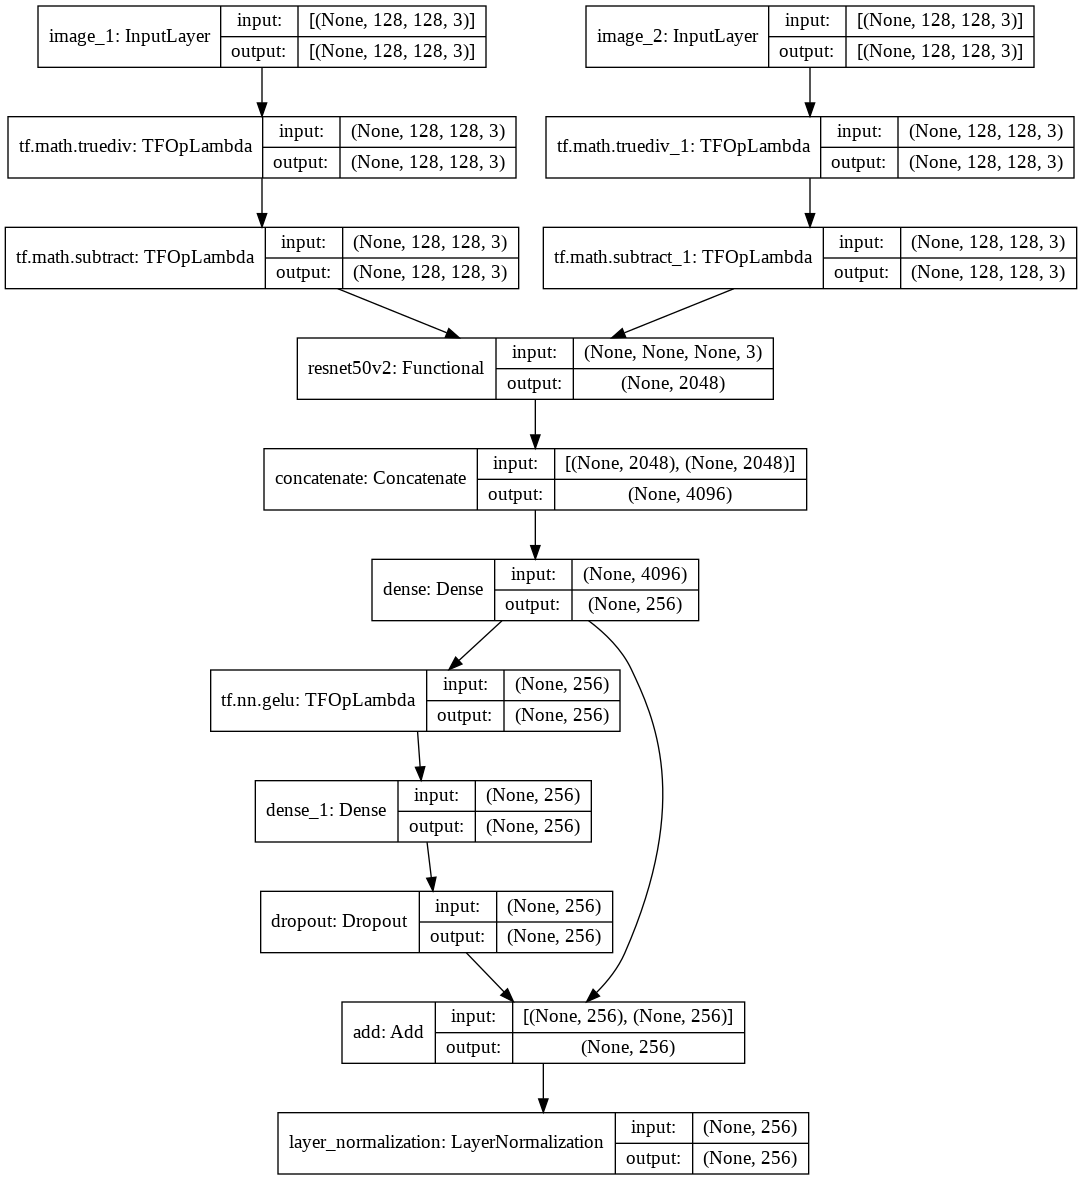

In [27]:
vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
keras.utils.plot_model(vision_encoder, show_shapes=True)

In [28]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        bert_model_path,
        name="bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    
    # Receive the text as inputs.
    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    inputs = {
        feature: keras.Input(shape=(128, ), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }
    
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

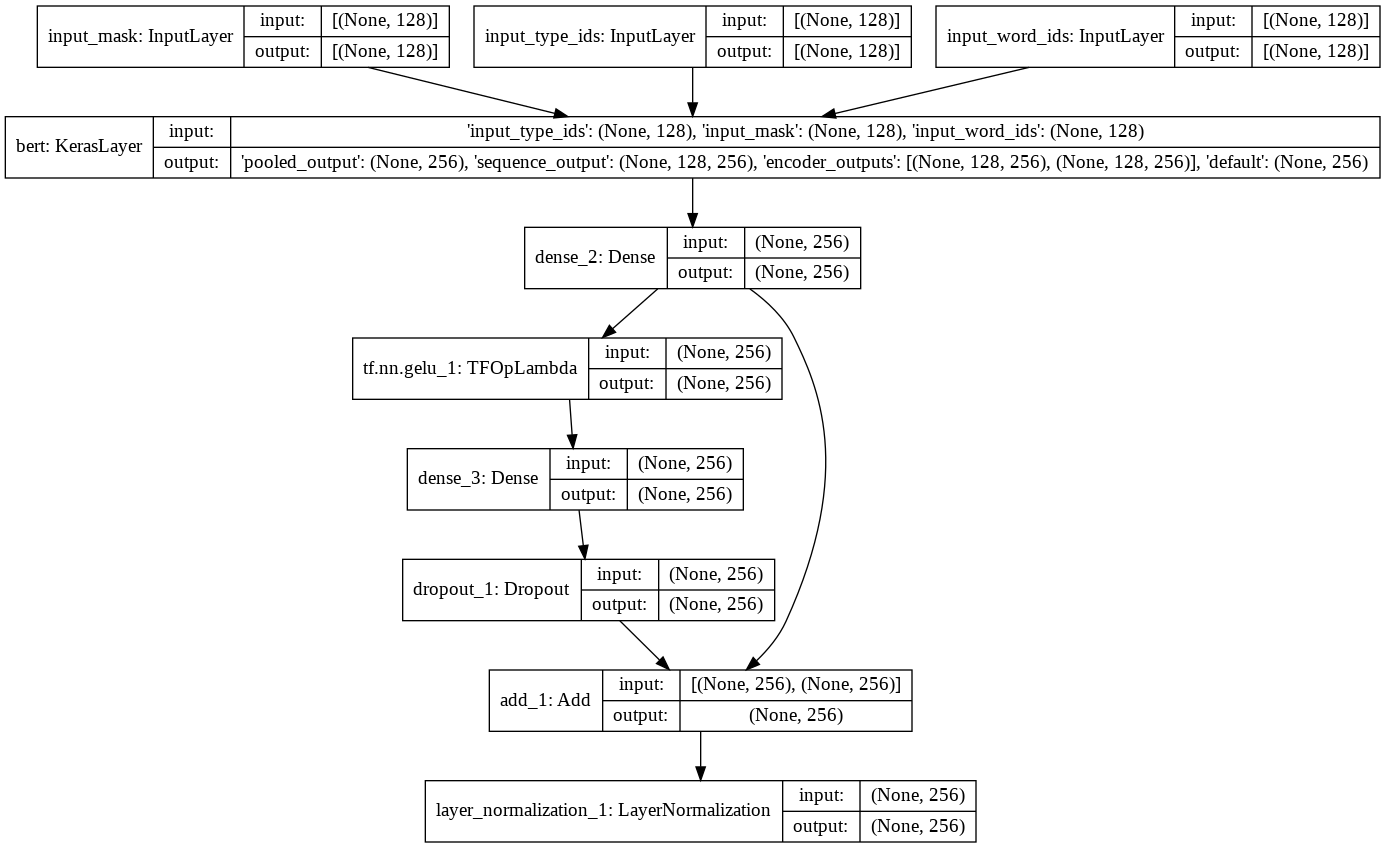

In [29]:
text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
keras.utils.plot_model(text_encoder, show_shapes=True)

In [30]:
def create_multimodal_model(num_projection_layers=1, projection_dims=256, dropout_rate=0.1, 
                     vision_trainable=False, text_trainable=False):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    text_inputs = {
        feature: keras.Input(shape=(128, ), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, vision_trainable)
    text_encoder = create_text_encoder(num_projection_layers, projection_dims, dropout_rate, text_trainable)

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)

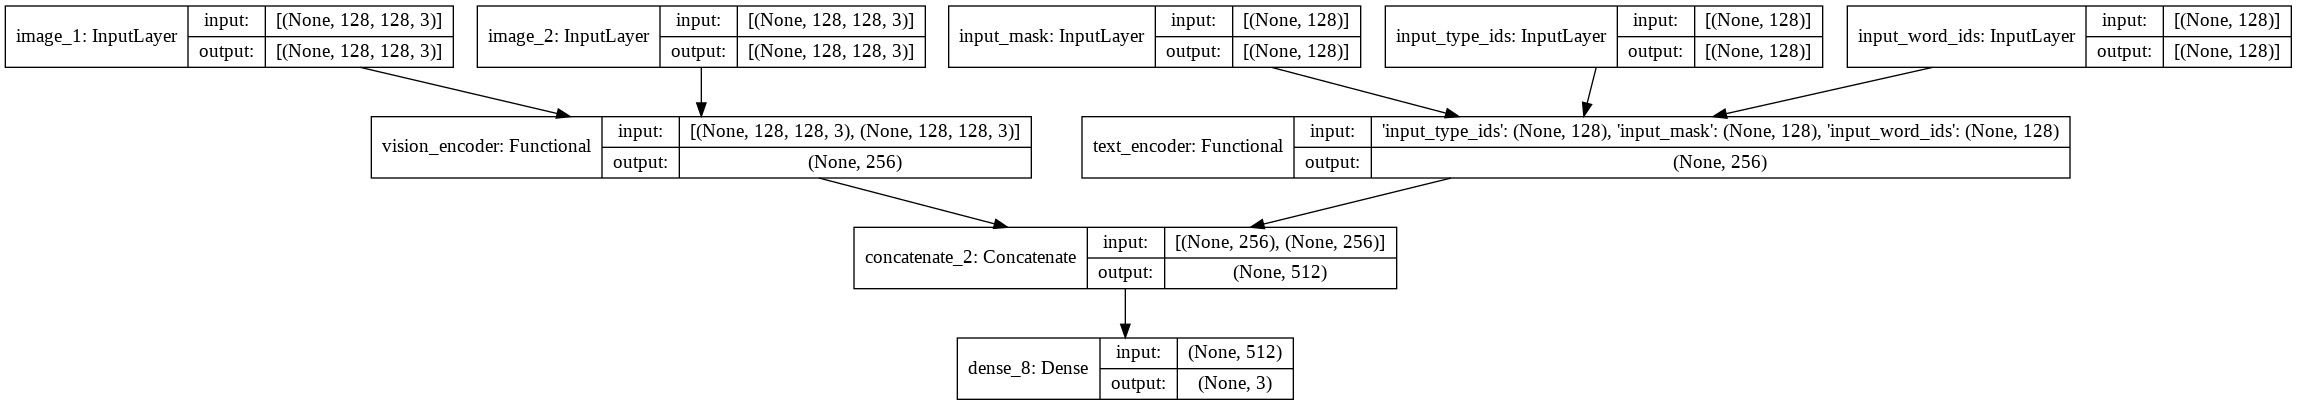

In [31]:
multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

You are encouraged to play with the different hyperparameters involved in building this model and observe how the final performance is affected. 

## Compile and train the model

In [32]:
multimodal_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [33]:
history = multimodal_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
38/38 [==============================] - 28s 490ms/step - loss: 0.9491 - accuracy: 0.8271 - val_loss: 0.5954 - val_accuracy: 0.8571
Epoch 2/10
38/38 [==============================] - 17s 454ms/step - loss: 0.4167 - accuracy: 0.8855 - val_loss: 0.5714 - val_accuracy: 0.8571
Epoch 3/10
38/38 [==============================] - 17s 455ms/step - loss: 0.3522 - accuracy: 0.8922 - val_loss: 0.5974 - val_accuracy: 0.8571
Epoch 4/10
38/38 [==============================] - 17s 453ms/step - loss: 0.2636 - accuracy: 0.9089 - val_loss: 0.7920 - val_accuracy: 0.8254
Epoch 5/10
38/38 [==============================] - 17s 445ms/step - loss: 0.2178 - accuracy: 0.9265 - val_loss: 0.7151 - val_accuracy: 0.8413
Epoch 6/10
38/38 [==============================] - 17s 445ms/step - loss: 0.1683 - accuracy: 0.9507 - val_loss: 1.0525 - val_accuracy: 0.8413
Epoch 7/10
38/38 [==============================] - 17s 456ms/step - loss: 0.1265 - accuracy: 0.9541 - val_loss: 1.1263 - val_accuracy: 0.7937

## Evaluate the model

In [34]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 4s 522ms/step - loss: 1.3224 - accuracy: 0.7786
Accuracy on the test set: 77.86%.


In [35]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = list(label_map.keys())

def detailed_test_eval(model):
    prediction_labels = np.argmax(model.predict(test_ds), 1)
    print(classification_report(test_labels, prediction_labels, target_names=class_names))
    return pd.DataFrame(confusion_matrix(test_labels, prediction_labels),
                        index=class_names, columns=class_names)

In [36]:
detailed_test_eval(multimodal_model)

               precision    recall  f1-score   support

Contradictory       0.67      0.55      0.60        11
      Implies       0.00      0.00      0.00        11
 NoEntailment       0.90      0.87      0.88       118

     accuracy                           0.78       140
    macro avg       0.52      0.47      0.49       140
 weighted avg       0.81      0.78      0.79       140



,Contradictory,Implies,NoEntailment
Contradictory,6,2,3
Implies,2,0,9
NoEntailment,1,14,103


We can observe that this model is performing poorly on the rare classes. Since the dataset is imbalanced we would want to let our model know about that by using better informed losses. 

## Loss weighted training 

In [40]:
# Reference: https://bit.ly/3xxtgSy

train_labels_ohe = keras.utils.to_categorical(train_labels)
class_totals = train_labels_ohe.sum(axis=0)
class_weight = dict()

for i in range(0, len(class_totals)):
	class_weight[i] = class_totals.max() / class_totals[i]

class_weight

{0: 10.870968, 1: 10.870968, 2: 1.0}

In [41]:
multimodal_model_lw = create_multimodal_model()
multimodal_model_lw.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)
history = multimodal_model_lw.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/10
38/38 [==============================] - 26s 475ms/step - loss: 4.4089 - accuracy: 0.4637 - val_loss: 1.8073 - val_accuracy: 0.0794
Epoch 2/10
38/38 [==============================] - 17s 457ms/step - loss: 2.3094 - accuracy: 0.5664 - val_loss: 0.8733 - val_accuracy: 0.6508
Epoch 3/10
38/38 [==============================] - 17s 439ms/step - loss: 1.6662 - accuracy: 0.7444 - val_loss: 1.2598 - val_accuracy: 0.4127
Epoch 4/10
38/38 [==============================] - 17s 442ms/step - loss: 1.1856 - accuracy: 0.7769 - val_loss: 0.9210 - val_accuracy: 0.6667
Epoch 5/10
38/38 [==============================] - 17s 452ms/step - loss: 0.8023 - accuracy: 0.8697 - val_loss: 0.9199 - val_accuracy: 0.7143
Epoch 6/10
38/38 [==============================] - 17s 457ms/step - loss: 0.5690 - accuracy: 0.9173 - val_loss: 1.1037 - val_accuracy: 0.7778
Epoch 7/10
38/38 [==============================] - 17s 446ms/step - loss: 0.4135 - accuracy: 0.9490 - val_loss: 1.2980 - val_accuracy: 0.8254

In [42]:
_, acc = multimodal_model_lw.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 3s 343ms/step - loss: 1.5131 - accuracy: 0.6786
Accuracy on the test set: 67.86%.


In [43]:
detailed_test_eval(multimodal_model_lw)

               precision    recall  f1-score   support

Contradictory       0.38      0.55      0.44        11
      Implies       0.07      0.18      0.11        11
 NoEntailment       0.90      0.74      0.81       118

     accuracy                           0.68       140
    macro avg       0.45      0.49      0.45       140
 weighted avg       0.79      0.68      0.73       140



,Contradictory,Implies,NoEntailment
Contradictory,6,2,3
Implies,2,2,7
NoEntailment,8,23,87


Even though the top-1 accuracy is worse we notice that our model's performance on the rare classes has improved a bit. Let's try [Focal Loss](https://arxiv.org/abs/1708.02002) which is, by design, a better choice for a loss function when dealing with imbalanced classification datasets. 

## Focal loss

In [47]:
!pip install -q focal-loss

In [48]:
from focal_loss import SparseCategoricalFocalLoss

In [49]:
multimodal_model_focal = create_multimodal_model()
multimodal_model_focal.compile(
    optimizer="adam", loss=SparseCategoricalFocalLoss(gamma=2), metrics="accuracy"
)
history = multimodal_model_focal.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
38/38 [==============================] - 26s 472ms/step - loss: 0.6861 - accuracy: 0.8028 - val_loss: 0.2574 - val_accuracy: 0.8413
Epoch 2/10
38/38 [==============================] - 17s 454ms/step - loss: 0.1690 - accuracy: 0.8713 - val_loss: 0.2817 - val_accuracy: 0.8571
Epoch 3/10
38/38 [==============================] - 17s 444ms/step - loss: 0.1294 - accuracy: 0.8839 - val_loss: 0.3052 - val_accuracy: 0.8571
Epoch 4/10
38/38 [==============================] - 17s 438ms/step - loss: 0.0877 - accuracy: 0.9190 - val_loss: 0.3739 - val_accuracy: 0.8730
Epoch 5/10
38/38 [==============================] - 17s 439ms/step - loss: 0.0535 - accuracy: 0.9474 - val_loss: 0.4769 - val_accuracy: 0.8254
Epoch 6/10
38/38 [==============================] - 17s 452ms/step - loss: 0.0291 - accuracy: 0.9733 - val_loss: 0.4550 - val_accuracy: 0.6508
Epoch 7/10
38/38 [==============================] - 17s 436ms/step - loss: 0.0406 - accuracy: 0.9574 - val_loss: 0.5999 - val_accuracy: 0.8571

In [50]:
_, acc = multimodal_model_focal.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 3s 348ms/step - loss: 0.5121 - accuracy: 0.8643
Accuracy on the test set: 86.43%.


In [51]:
detailed_test_eval(multimodal_model_focal)

               precision    recall  f1-score   support

Contradictory       0.60      0.55      0.57        11
      Implies       0.25      0.09      0.13        11
 NoEntailment       0.90      0.97      0.93       118

     accuracy                           0.86       140
    macro avg       0.58      0.53      0.55       140
 weighted avg       0.83      0.86      0.84       140



,Contradictory,Implies,NoEntailment
Contradictory,6,1,4
Implies,2,1,8
NoEntailment,2,2,114


Trade-off wise, focal loss beats the previous two approaches. Focal loss has two hyperparameters (alpha and gamma) and tuning them might lead to even better results. 

## Notes

* We used a smaller variant of the original BERT model. Chances are likely that with a larger variant, this performance will be improved. TensorFlow Hub [provides](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub) a number of different BERT models that you can experiment with.
* We kept the pre-trained models frozen. Fine-tuning them on the multimodal entailment task would have resulted in a better performance.
* We built a simple baseline model for the multimodal entailment task. There are various approaches that have been proposed to tackle the entailment problem. [This presentation deck](https://docs.google.com/presentation/d/1mAB31BCmqzfedreNZYn4hsKPFmgHA9Kxz219DzyRY3c/edit?usp=sharing) from the [Recognizing Multimodal Entailment](https://multimodal-entailment.github.io/) tutorial provides a comprehensive overview. 